In [12]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer, fig_3D_ilr_space
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go

In [13]:
K = 10         #Index of the instance you want to test in the test set
N_class = 6    #Number of class, the dimension of the simplex is therefore N_class-1
N_feat  = 6    #In this example, since the number of feature of the digit dataset is quite large (64), we propose to reduce it with a PCA

#load the dataset, take a subset of N_class classes, scale it and split into a training and testing set
X, Y = datasets.load_digits(return_X_y=True)
subset_i = np.where(Y < N_class)
X = X[subset_i]
Y = Y[subset_i]
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Reduce the number of feature to N_feat with a PCA
pca = PCA(n_components=N_feat)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)


#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

SVC(probability=True)

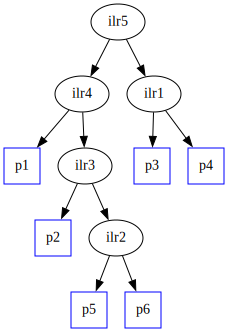

In [14]:
#Choose a sequential binary partition matrix and plot the corresponding bifurcation tree
sbpmatrix = np.array([[1,1,-1,-1,1,1],[1,-1,0,0,-1,-1],[0,1,0,0,-1,-1],[0,0,0,0,1,-1],[0,0,1,-1,0,0]])
basis = np.flip(sbp_basis(sbpmatrix), axis=0)
root = create_tree_from_sbp(sbpmatrix, 6)

##Visualise the tree using graphviz
graph = init_graph()
build_graph(root, graph)
#graph.render('tree.pdf', view=True)
graph       #plot the bifurcation tree


In [15]:

# explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class, sbpmatrix=sbpmatrix)
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(Y_test[K])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred, basis=basis)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)

True label of the tested instance: 2
Prediction on the simplex: [[0.00456465 0.00374668 0.1703771  0.70399263 0.00634397 0.11097495]]
Prediction in the ILR space: [-1.00321033 -2.02359752 -1.5983205  -0.95916699 -4.03958744]
Sum of the shapley composition and the base distribution in the ILR space: [-1.00321034 -2.02359754 -1.5983205  -0.959167   -4.03958747]


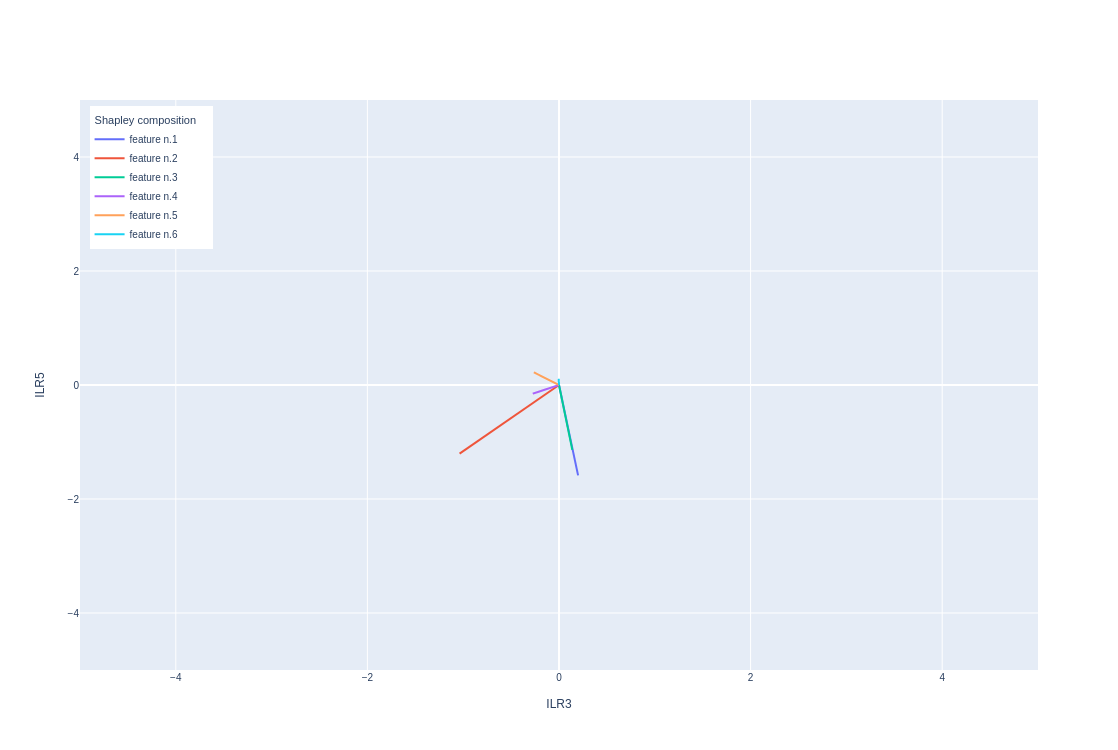

In [30]:
#PLOT THE SHAPLEY COMPOSITION IN THE 2D SUBSPACE CORRESPONDING THE CHOSEN BALANCES (ILR COMPONENTS) b1 AND b2.
figsize = 750    #size of the figure
lim     = 5      #plot range [-lim, lim] for both dimensions

#Choose the balances (check out the bifurcation tree to choose which groups of parts (probabilities) you want to compare):
b1 = 3   #(ilr3)
b2 = 5   #(ilr5)

fig = go.Figure(layout=go.Layout(autosize=False, width=figsize, height=figsize))
fig.update_xaxes(range=[-lim, lim])
fig.update_yaxes(range=[-lim, lim])
fig.update_layout(xaxis_title="ILR"+str(b1), yaxis_title="ILR"+str(b2), legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01), font=dict(size=10))

#Draw the shapley compositions
for i,s in enumerate(shapley):
    fig.add_trace(go.Scatter(x=[0,s[b1-1]],y=[0,s[b2-1]], mode='lines', name='feature n.'+str(i+1),
                             legendgroup='shapley', legendgrouptitle_text='Shapley composition'))

fig.show()

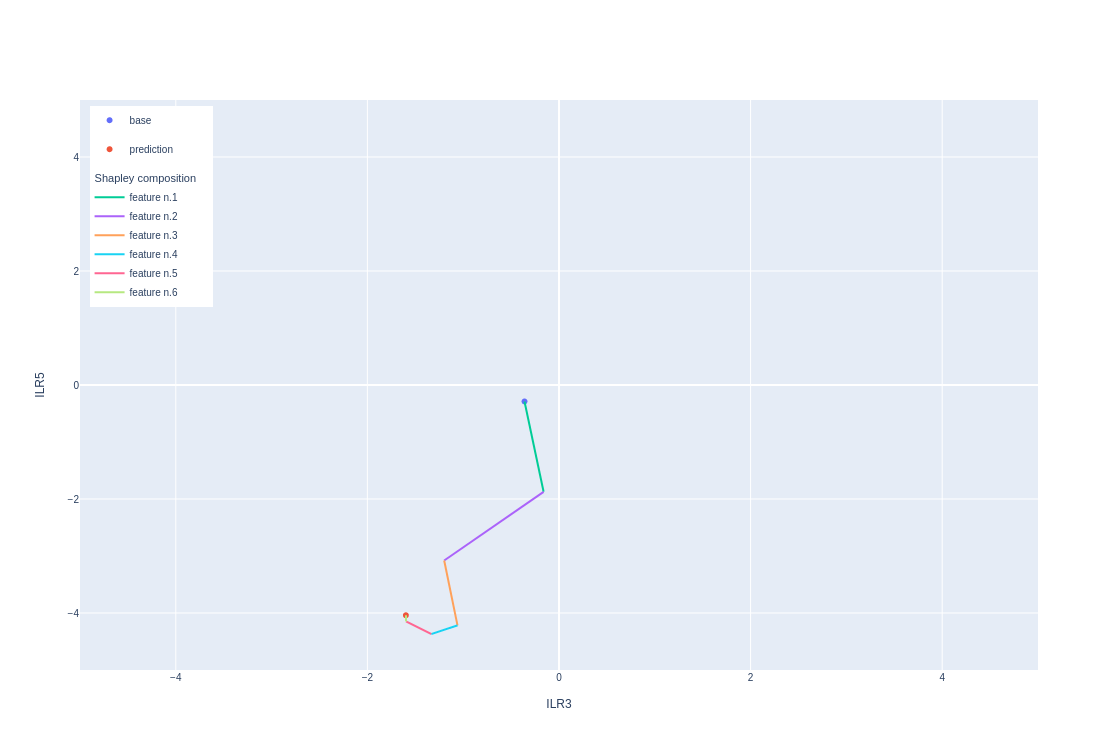

In [31]:
#PLOT THE SHAPLEY COMPOSITION IN THE 2D SUBSPACE CORRESPONDING TO THE CHOSEN BALANCES 

fig = go.Figure(layout=go.Layout(autosize=False, width=figsize, height=figsize))
fig.update_xaxes(range=[-lim, lim])
fig.update_yaxes(range=[-lim, lim])
fig.update_layout(xaxis_title="ILR"+str(b1), yaxis_title="ILR"+str(b2), legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01), font=dict(size=10))


#Draw base distribution and prediction
fig.add_trace(go.Scatter(x=[base[b1-1]], y=[base[b2-1]], mode='markers', name='base'))
fig.add_trace(go.Scatter(x=[ilr_pred[b1-1]], y=[ilr_pred[b2-1]], mode='markers', name='prediction'))


s = base.copy()

for i,p in enumerate(shapley):
    fig.add_trace(go.Scatter(x=[s[b1-1],(s+p)[b1-1]], y=[s[b2-1],(s+p)[b2-1]], mode='lines', name='feature n.'+str(i+1),
                             legendgroup='shapley', legendgrouptitle_text='Shapley composition'))
    s += p

fig.show()